# **Linear Regression**

A linear regression model with both L1 and L2 regularization will be implemented. The class LinearRegression will have the following API:

* `__init__(alpha, tol, max_iter, theta_init, penalty, lambd)`
* `compute_cost(theta, X, y)`
* `compute_gradient(theta, X, y)`
* `fit(X, y)`
* `has_converged(theta_old, theta_new)`
* `predict(X)`

### **Cost Function**

The cost function computes the scalar cost for a given $\theta$ vector. 

> $
\mathcal{L}({\theta}) = \frac{1}{N}\sum_{i =1}^N (h_{{\theta}}({x}_i) - y_i)^2
$

where

> $h_{{\theta}}({x}_i) = \theta^Tx_i$

L1 Regularization Loss:
>$
\mathcal{L_1}({\theta}) = \mathcal{L}({\theta}) + \lambda\sum_{j = 1}^D  |{\theta}_j|
$

L2 Regularization Loss:
>$
\mathcal{L_2}({\theta}) = \mathcal{L}({\theta}) + \lambda\sum_{j = 1}^D  {\theta}_j^2 
$

$N$ is the number of training samples and $D$ is the number of features (excluding the intercept term). $\theta$ is a $D + 1$ dimensional vector, with the first element being the intercept term. 

In [ ]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
np.random.seed(42)

import dill
import base64

In [ ]:
class LinearRegression:

    """
    Linear Regression

    Parameters
    ----------
    alpha: float, default=0.01
        Learning rate
    tol : float, default=0.0001
        Tolerance for stopping criteria
    max_iter : int, default=10000
        Maximum number of iterations of gradient descent
    theta_init: None (or) numpy.ndarray of shape (D + 1,)
        The initial weights; if None, all weights will be zero by default
    penalty : string, default = None
        The type of regularization. The other acceptable options are l1 and l2
    lambd : float, default = 1.0
        The parameter regularisation constant (i.e. lambda)

    Attributes
    ----------
    theta_ : numpy.ndarray of shape (D + 1,)
        The value of the coefficients after gradient descent has converged
        or the number of iterations hit the maximum limit
    hist_theta_ : numpy.ndarray of shape (num_iter, D + 1) where num_iter is the number of gradient descent iterations
        Stores theta_ after every gradient descent iteration
    hist_cost_ : numpy.ndarray of shape (num_iter,) where num_iter is the number of gradient descent iterations
        Stores cost after every gradient descent iteration
    """
    
    def __init__(self, alpha = 0.01, tol=1e-4, max_iter = 100, theta_init = None, penalty = None, lambd = 0):
        
        self.alpha = alpha
        self.theta_init = theta_init
        self.max_iter = max_iter
        self.tol = tol
        self.penalty = penalty
        self.lambd = lambd

        self.theta_ = None
        self.hist_cost_ = None
        self.hist_theta_ = None
    
    def compute_cost(self, theta, X, y):
    
        """
        Compute the cost/objective function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        cost: float
            The cost as a scalar value
        """
        h = np.matmul(X, theta) # (N, )
        L = np.mean(np.square(h - y)) # scalar
        L1 = L + self.lambd*np.sum(np.abs(theta[1:]))
        L2 = L + self.lambd*np.sum(np.square(theta[1:]))
        if self.penalty == 'l1': return L1
        elif self.penalty == 'l2': return L2


    def compute_gradient(self, theta, X, y):
    
        """
        Compute the gradient of the cost function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        gradient: numpy.ndarray of shape (D + 1,)
            The gradient values
        """
        
        h = np.matmul(X, theta) # (N, D+1)
        delta_y = h - y # (N, )
        dL = 2*np.matmul(X.T, delta_y)/len(y) # (D+1, )
        dL1 = dL + np.insert(self.lambd*np.sign(theta[1:]),0,0)  # (D+1, )
        dL2 = dL + np.insert(2*self.lambd*theta[1:],0,0) # (D+1, )
        if self.penalty == 'l1': return dL1
        elif self.penalty == 'l2': return dL2
        else: return dL

    def has_converged(self, theta_old, theta_new):

        """
        Return whether gradient descent has converged.

        Parameters
        ----------
        theta_old: numpy.ndarray of shape (D + 1,)
            The weights prior to the update by gradient descent
        theta_new: numpy.ndarray of shape (D + 1,)
            The weights after the update by gradient descent

        Returns
        -------
        converged: bool
            Whether gradient descent converged or not
        """

        norm_2 = np.linalg.norm((theta_old - theta_new),2)
        if norm_2 <= self.tol: return True
        else: return False

    def fit(self, X, y):

        """
        Compute the coefficients using gradient descent and store them as theta_.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        Nothing
        """

        N, D = X.shape
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))
        
        if self.theta_init is None:
            theta_old = np.zeros((D + 1,))
        else:
            theta_old = self.theta_init

        self.hist_theta_ = np.array([theta_old])
        cost = self.compute_cost(theta_old, X, y)
        self.hist_cost_ = np.array([cost])
        
        for i in range(self.max_iter):
            grad = self.compute_gradient(theta_old, X, y)
            theta_new = theta_old - self.alpha*grad
            cost = self.compute_cost(theta_old, X, y)
            self.hist_cost_ = np.vstack([self.hist_cost_, cost])
            self.hist_theta_ = np.vstack([self.hist_theta_, theta_new])
            if self.has_converged(theta_old, theta_new):
                break
            theta_old = theta_new
        self.theta_ = theta_new

    def predict(self, X):

        """
        Predict the target variable values for the data points in X.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        y_hat: numpy.ndarray of shape (N,)
            The predicted target variables values for the data points in X
        """

        N = X.shape[0]
        X = np.hstack((np.ones((N, 1)), X))
        
        return np.matmul(X,self.theta_)

## **1.2. Synthetic dataset**

In this section we will first create some synthetic data on which we will run your linear regression implementation. We are creating 100 datapoints around the function y = mx + b, introducing Gaussian noise.

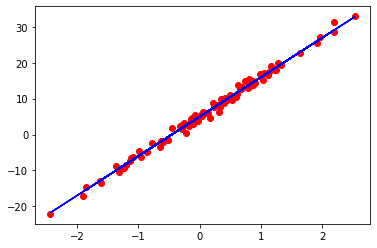

In [ ]:
num_samples = 100
np.random.seed(1)
noise = np.random.randn(num_samples, 1)
X = np.random.randn(num_samples, 1)

y_ideal = 11*X + 5
y_real = (11*X + 5) + noise

plt.plot(X, y_real, 'ro')
plt.plot(X, y_ideal, 'b')